- [Figure 2](#Figure-2)
- [Table 1](#Table-1)
- [Table 2](#Table-2)
- [Table 3](#Table-3)
- [Extension](#Extension)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats.qmc import Halton
from linearmodels.panel import PanelOLS
from statsmodels.api import Logit
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.patches as mpatches

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
url= "https://raw.githubusercontent.com/ZeliaDec/Econ/main/"
data1 = pd.read_stata(url+"T2_data.dta")
facilities = pd.read_csv(url+"facilities.csv") #from 1996-2015, coal as primary fuel type and electric utilities only
emissions = pd.read_csv(url+"ozone-emissions.csv")#from CAMPD
data2 = pd.read_stata(url+"T_3_4.dta")

# Figure 2
************************************************************************
				VARIABLES 							
*************************************************************************
					
- IN_DATA	A dummy indicating whether the unit is included in the analysis
 			(units are excluded if one or more variables are missing).
- FAC_ID	A unique facility identifier
- OWN_ID	A unique owner identifier
- UNIt_ID	A unique boiler identifier
- REGIME	Indicates if the facility is deregulated (1) regulated (2) or public(3)					
- U_CAP		Summer capacity (MW)
- U_SUM_HR	Summer heat rate (kWh/btu)
- U_AGE		Plant age (as of 2000)
- U_SUM_CF	Plant capcity factor
- PRE_RET_	Pre-retrofit NOx emissions rate
					
- D_SCR		Dummy indicating SCR retrofit
- D_SNCR	Dummy indicating SNCR retrofit
- D_LN		Dummy indicating LNB retrofit
- D_CM		Dummy indicating CM retrofit					
- D_NO		Dummy indicating no retrofit

- C_CM		CM retrofit dummy * capacity	
- C_NONE	No retrofit dummy * capacity	
- C_LN		LN retrofit dummy * capacity	
- C_SC		SC retrofit dummy * capacity						
- C_SN	  	SN retrofit dummy * capacity	

- REG		Regulated unit dummy
- PUB		Public dummy
- UNREG		Unregulated unit dummy

**************************************************************************************/

In [4]:
data1 = data1[data1['IN_DATA']==1]

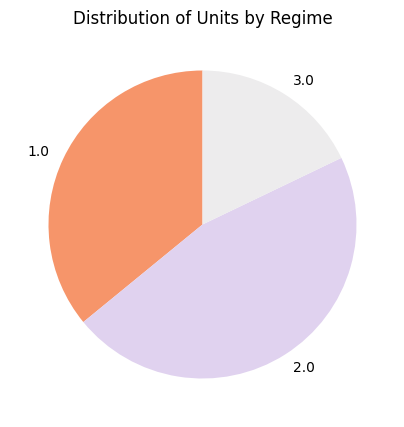

In [5]:
by_regime=data1.groupby('REGIME').size().reset_index()
colours = {
    1.0:'de', #deregulated
    2.0:'#e0d2ef', #regulated
    3.0: '#edeced' #public  
}

# Plotting
plt.figure(figsize=(5, 5))
plt.pie(
    by_regime[0], 
    labels=by_regime['REGIME'],
    startangle=90, 
    colors=['#f6956a','#e0d2ef','#edeced']
)
plt.title('Distribution of Units by Regime')
plt.show()

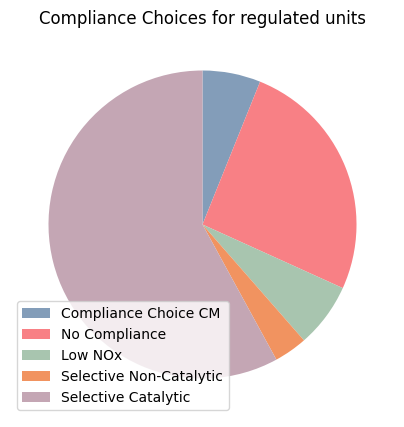

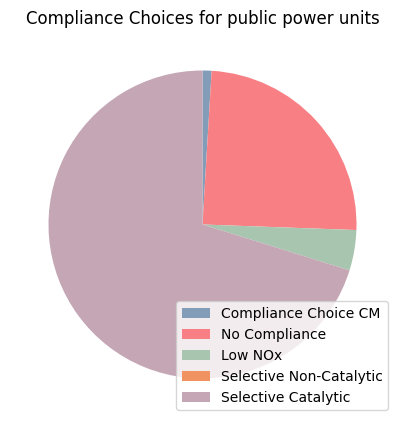

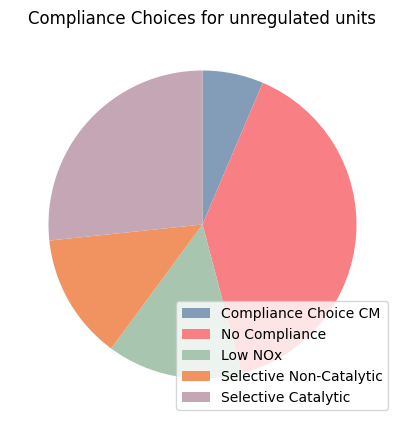

In [6]:
# Generate table for compliance choices by regime
compliance_choices = data1.groupby("REGIME")[["C_CM", "C_NONE", "C_LN", "C_SN", "C_SC"]].sum().reset_index()


def plot_pie_chart(regime,regime_name):
    color_palette = {
    "C_CM": "#839db9",    #Blue
    "C_NONE": "#f88085",  #Pinkish red
    "C_LN": "#a8c5af", #Green 
    "C_SN": "#f19360", #Orange
    "C_SC": "#c4a6b4"    # Purple
    }
    # Filter rows for the current regime
    regime_data = compliance_choices[compliance_choices['REGIME'] == regime]
    
    # Drop the REGIME column and transpose to get a single Series for pie chart
    regime_data = regime_data.drop(columns=['REGIME']).iloc[0]
    
    # Map colors to the columns
    colors = [color_palette[col] for col in regime_data.index]
    
    # Custom labels for the legend
    custom_labels = {
        "C_CM": "Compliance Choice CM",
        "C_NONE": "No Compliance",
        "C_LN": "Low NOx",
        "C_SC": "Selective Catalytic",
        "C_SN": "Selective Non-Catalytic"
    }
    
    
    
    # Plot the pie chart
    plt.figure(figsize=(5, 5))
    regime_data.plot.pie(
        labels=None, 
        startangle=90,
        colors=colors,
        counterclock=False,
        legend=True,
    )
    # Add a custom legend
    plt.legend(
        labels=[custom_labels[col] for col in regime_data.index],  # Custom legend labels
        loc='best'
    )
    # Add title and remove y-label
    plt.title(f"Compliance Choices for {regime_name}")
    plt.ylabel("")# Remove the y-axis label for cleaner look
    plt.show()
   
plot_pie_chart(2,'regulated units')
plot_pie_chart(3,'public power units')
plot_pie_chart(1,'unregulated units')


In [7]:
# Summary statistics for missing data
missing_data_summary = data1.groupby("IN_DATA").agg({
    "U_CAP": ["mean", "count"],
    "U_AGE": ["mean", "count"]
})
print("\nSummary Statistics for Missing Data:")
print(missing_data_summary)


Summary Statistics for Missing Data:
              U_CAP            U_AGE      
               mean count       mean count
IN_DATA                                   
1.0      271.716309   632  36.167721   632


# Table 1

In [8]:
# Filter to include only rows where IN_DATA == 1
filtered_data = data1[data1["IN_DATA"] == 1]

In [9]:
import numpy as np
import pandas as pd
import textwrap

# Function to process and transpose summary data
def process_summary(data, columns_map, index_map):
    # Rename columns
    data.columns = [f"{columns_map[col]} mean" if func == "mean" else f"{columns_map[col]} std" for col, func in data.columns]
    data.index = data.index.map(index_map)
    
    # Ensure all data is numeric before processing
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Round and format values
    for col in data.columns:
        if "Pre-retrofit NO x emissions (lbs/mmBtu)" in col:
            data[col] = data[col].round(2)  # Round NO x emissions to 2 decimals
        else:
            data[col] = data[col].round(0).astype(int)  # Round others to integers
    
    # Split into mean and std data
    mean_values = data.iloc[:, ::2]
    std_values = data.iloc[:, 1::2].apply(lambda col: col.round(2) if "Pre-retrofit NO x emissions (lbs/mmBtu)" in col.name else col.round(0))  # Ensure proper rounding
    std_values = std_values.applymap(lambda x: f"({x:.2f})" if isinstance(x, float) else f"({x})")  # Format as string with 2 decimals if float
    
    # Clean column names
    mean_values.columns = [col.replace(" mean", "") for col in mean_values.columns]
    std_values.columns = [col.replace(" std", " (std)") for col in std_values.columns]
    
    # Combine mean and std
    combined_summary = pd.concat([mean_values, std_values], axis=1)
    combined_summary = combined_summary.T
    
    # Reorder rows
    ordered_rows = []
    for col in mean_values.columns:
        ordered_rows.append(col)
        ordered_rows.append(f"{col} (std)")
    combined_summary = combined_summary.loc[ordered_rows]
    
    return combined_summary

# Index map
index_map = {
    1.0: "Deregulated",
    2.0: "Regulated",
    3.0: "Public"
}

# Step 1: Group and aggregate data for facilities and companies
grouped_data1 = filtered_data.groupby("REGIME")[["FAC_ID", "OWN_ID"]].nunique()
grouped_data2 = filtered_data.groupby("REGIME")[["UNIT_ID"]].count()
grouped_data = pd.concat([grouped_data2, grouped_data1], axis=1)

grouped_data = grouped_data.rename(columns={
    "UNIT_ID": "Number of units",
    "FAC_ID": "Number of facilities",
    "OWN_ID": "Number of companies/ public agencies"
})
grouped_data.index = grouped_data.index.map(index_map)
transposed_data = grouped_data.T

# Step 2: Group and aggregate data for capacity and age
capacity_age_summary = filtered_data.groupby("REGIME").agg({
    "U_CAP": ["mean", "std"],
    "U_AGE": ["mean", "std"]
}).round(0).astype(int)
combined_capacity_age_summary = process_summary(capacity_age_summary, {
    "U_CAP": "Capacity (MW)",
    "U_AGE": "Unit age (years)"
}, index_map)

# Step 3: Summarize heat rate and emissions rates
heat_emissions_summary = filtered_data.groupby("REGIME").agg({
    "U_SUM_HR": ["mean", "std"],
    "PRE_RET_MNEMI": ["mean", "std"]
})
combined_heat_emissions_summary = process_summary(heat_emissions_summary, {
    "U_SUM_HR": "Pre-retrofit heat rate (kWh/btu)",
    "PRE_RET_MNEMI": "Pre-retrofit NO x emissions (lbs/mmBtu)"
}, index_map)

# Step 4: Summarize summer capacity factors
capacity_factors_summary = filtered_data.groupby("REGIME").agg({
    "U_SUM_CF": ["mean", "std"]
}).round(0).astype(int)
combined_capacity_factors_summary = process_summary(capacity_factors_summary, {
    "U_SUM_CF": "Pre-retrofit summer capacity factor (percent)"
}, index_map)

# Step 5: Combine all summaries into one table
final_summary = pd.concat([
    transposed_data, 
    combined_capacity_age_summary, 
    combined_heat_emissions_summary, 
    combined_capacity_factors_summary
])

final_summary.columns.name = "Variable"

# Print the final combined table
#print(final_summary)

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12991/3967047294.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  std_values = std_values.applymap(lambda x: f"({x:.2f})" if isinstance(x, float) else f"({x})")  # Format as string with 2 decimals if float
/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12991/3967047294.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  std_values = std_values.applymap(lambda x: f"({x:.2f})" if isinstance(x, float) else f"({x})")  # Format as string with 2 decimals if float
/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12991/3967047294.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  std_values = std_values.applymap(lambda x: f"({x:.2f})" if isinstance(x, float) else f"({x})")  # Format as string with 2 decimals if float


In [10]:
from IPython.core.display import display, HTML

# Function to generate HTML table with styling
def generate_html_table(df, title_text):
    """
    Generates an HTML table with dynamically wrapped variable names and a custom title.
    """

    # Convert the DataFrame to an HTML table
    html_table = df.to_html(escape=False, index_names=True, border=0)

    # Add styling to mimic the desired format
    style = """
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
            font-size: 14px;
            font-family: Arial, sans-serif;
            text-align: center;
        }
        th, td {
            padding: 8px;
            border: 1px solid #ddd;
            background-color: white;
            color: black;
        }
        th {
            background-color: white;
            font-weight: bold;
        }
        tr:nth-child(even) {
            background-color: white;
        }
        td:first-child {
            text-align: right;
            width: 20%;
        }
    </style>
    """

    # Add title and horizontal lines
    title = f"<h2><center>{title_text}</center></h2><hr><hr>"

    return title + style + html_table

title_text = "Table 1 - Summary Statistics By Unit Type"
html_output = generate_html_table(final_summary, title_text)

# Display the HTML table
display(HTML(html_output))

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12991/1324701147.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Variable,Deregulated,Regulated,Public
Number of units,227,292,113
Number of facilities,86,100,34
Number of companies/ public agencies,34,33,15
Capacity (MW),249,314,208
Capacity (MW) (std),(212),(279),(227)
Unit age (years),37,36,35
Unit age (years) (std),(11),(11),(11)
Pre-retrofit heat rate (kWh/btu),12120,11866,12184
Pre-retrofit heat rate (kWh/btu) (std),(4747),(5956),(1898)
Pre-retrofit NO x emissions (lbs/mmBtu),0.48,0.54,0.55


# Table 2

In [11]:
# Create new variables (equivalent to "gen" and "replace" in Stata)
data2['CS_CM'] = np.where(
    (data2['C_CM'] == 1) | (data2['C_OFA'] == 1), 1, 0
)

data2['CS_LN'] = np.where(
    (data2['C_LNC1'] == 1) | (data2['C_LNC2'] == 1) |
    (data2['C_LNC3'] == 1) | (data2['C_LNB'] == 1) |
    (data2['C_LNBO'] == 1), 1, 0
)

data2['CHOICE'] = (
    data2['C_CM_LNC1'] + data2['C_CM'] + data2['C_LNC1'] +
    data2['C_LNC2'] + data2['C_LNC3'] + data2['C_LNC3_SCR'] +
    data2['C_LNB'] + data2['C_LNBO'] + data2['C_LOSC'] +
    data2['C_NONE'] + data2['C_OFA'] + data2['C_OSNCR'] +
    data2['C_SCR'] + data2['C_SNCR']
)

# Group by REGIME and TECH_FINAL and compute summary statistics
table_2 = data2.groupby(['REGIME', 'TECH_FINAL']).agg(
    F_mean=('F', 'mean'),
    F_sd=('F', 'std'),
    V1_mean=('V1', 'mean'),
    V1_sd=('V1', 'std')
).reset_index()

# Filter for specific TECH_FINAL values
table_2 = table_2[table_2['TECH_FINAL'].isin(['CM', 'LNB', 'SN', 'SC', 'N'])]

# Replace technology names
tech_map = {
    'CM': 'Combustion Modification',
    'LNB': 'Low NOx Burner',
    'SN': 'SNCR',
    'SC': 'SCR',
    'N': 'No Retrofit'
}
table_2['TECH_FINAL'] = table_2['TECH_FINAL'].map(tech_map)

# Round the values
table_2['F_mean'] = table_2['F_mean'].round(2)
table_2['F_sd'] = table_2['F_sd'].round(2)
table_2['V1_mean'] = (table_2['V1_mean'] * 100).round(2)
table_2['V1_sd'] = (table_2['V1_sd'] * 100).round(2)

# Replace regime values
table_2['REGIME'] = table_2['REGIME'].map({
    1.0: "Deregulated",
    2.0: "Regulated",
    3.0: "Public"
})

# Ensure the order of REGIME categories
table_2['REGIME'] = pd.Categorical(table_2['REGIME'], categories=["Deregulated", "Regulated", "Public"], ordered=True)

# Pivot the table to create multi-level columns
pivot_table = table_2.pivot(index='TECH_FINAL', columns='REGIME')

# Flatten the multi-level columns
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]

# Create a new DataFrame to organize the data with mean and std values in separate rows
organized_data = []

for tech in tech_map.values():
    tech_data = pivot_table.loc[tech]
    for regime in ['Deregulated', 'Regulated', 'Public']:
        organized_data.append([tech, regime, 'mean', tech_data[f'F_mean_{regime}'], tech_data[f'V1_mean_{regime}']])
        organized_data.append([tech, regime, 'std', f"({tech_data[f'F_sd_{regime}']:.2f})", f"({tech_data[f'V1_sd_{regime}']:.2f})"])

organized_df = pd.DataFrame(organized_data, columns=['TECH_FINAL', 'REGIME', 'Type', 'Capital cost', 'Operating cost'])

# Pivot the organized DataFrame to get the desired format
final_table = organized_df.pivot(index=['TECH_FINAL', 'Type'], columns='REGIME', values=['Capital cost', 'Operating cost'])

# Ensure the order of REGIME columns
final_table = final_table[['Capital cost', 'Operating cost']].reindex(columns=['Deregulated', 'Regulated', 'Public'], level=1)

#print("Table 2 - Compliance Cost Summary Statistics For Commonly Selected Control Technologies:")
#print(final_table)

In [12]:
title_text = "Table 2 - Compliance Cost Summary Statistics For Commonly Selected Control Technologies:"
html_output = generate_html_table(final_table, title_text)

# Display the HTML table
display(HTML(html_output))

# Table 3

In [13]:
# Create new variables (equivalent to "gen" and "replace" in Stata)
data2['CS_CM'] = np.where(
    (data2['C_CM'] == 1) | (data2['C_OFA'] == 1), 1, 0
)

data2['CS_LN'] = np.where(
    (data2['C_LNC1'] == 1) | (data2['C_LNC2'] == 1) |
    (data2['C_LNC3'] == 1) | (data2['C_LNB'] == 1) |
    (data2['C_LNBO'] == 1), 1, 0
)

data2['CHOICE'] = (
    data2['C_CM_LNC1'] + data2['C_CM'] + data2['C_LNC1'] +
    data2['C_LNC2'] + data2['C_LNC3'] + data2['C_LNC3_SCR'] +
    data2['C_LNB'] + data2['C_LNBO'] + data2['C_LOSC'] +
    data2['C_NONE'] + data2['C_OFA'] + data2['C_OSNCR'] +
    data2['C_SCR'] + data2['C_SNCR']
)

# Group by REGIME and compute summary statistics
table_3 = data2.groupby('REGIME').agg({
    'CHOICE': ['mean', 'std'],
    'CS_CM': 'mean',
    'CS_LN': 'mean',
    'C_SNCR': 'mean',
    'C_SCR': 'mean',
}).reset_index()

# Replace regime values
table_3['REGIME'] = table_3['REGIME'].map({
    1.0: "Deregulated",
    2.0: "Regulated",
    3.0: "Public"
})

# Flatten the multi-level columns
table_3.columns = ['_'.join(col).strip() if col[1] else col[0] for col in table_3.columns.values]

# Rename columns
table_3.rename(columns={
    'CHOICE_mean': '# Choices_mean',
    'CHOICE_std': '# Choices_std',
    'CS_CM_mean': 'Combustion modification/overfire air',
    'CS_LN_mean': 'LNB',
    'C_SNCR_mean': 'SNCR',
    'C_SCR_mean': 'SCR'
}, inplace=True)

# Convert specific columns to percentages
table_3['Combustion modification/overfire air'] *= 100
table_3['LNB'] *= 100
table_3['SNCR'] *= 100
table_3['SCR'] *= 100

# Round the values
table_3['# Choices_mean'] = table_3['# Choices_mean'].round(1)
table_3['# Choices_std'] = table_3['# Choices_std'].round(1)
table_3['Combustion modification/overfire air'] = table_3['Combustion modification/overfire air'].astype(int)
table_3['LNB'] = table_3['LNB'].astype(int)
table_3['SNCR'] = table_3['SNCR'].astype(int)
table_3['SCR'] = table_3['SCR'].astype(int)

# Pivot the table to make REGIME as columns
table_3_pivot = table_3.set_index('REGIME').T

# Add a line with NO x Control Technology and percent choice sets including technology
no_x_control_technology = pd.DataFrame({
    'Deregulated': [''],
    'Regulated': ['percent choice sets including technology'],
    'Public': ['']
}, index=['NO x Control Technology'])

# Combine the tables
final_table = pd.concat([table_3_pivot.loc[:'# Choices_std'], no_x_control_technology, table_3_pivot.loc['Combustion modification/overfire air':]])

#print("Table 3: - Choice Set Summary Statistics By Unit Type")
#print(final_table)

In [14]:
title_text = "Table 3: - Choice Set Summary Statistics By Unit Type"
html_output = generate_html_table(final_table, title_text)

# Display the HTML table
display(HTML(html_output))

,Deregulated,Regulated,Public
# Choices_mean,6.7,6.4,6.3
# Choices_std,1.8,1.9,1.9
NO x Control Technology,,percent choice sets including technology,
Combustion modification/overfire air,96.0,98.0,97.0
LNB,67.0,60.0,45.0
SNCR,90.0,96.0,91.0
SCR,100.0,100.0,100.0


# Extension

## Can operational characteristics predict managerial decisions to adopt SCR, even in the absence of explicit financial and regulatory considerations?

Optimization terminated successfully.
         Current function value: 0.409653
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Binary_Choice   No. Observations:                  567
Model:                          Logit   Df Residuals:                      561
Method:                           MLE   Df Model:                            5
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.3225
Time:                        16:16:48   Log-Likelihood:                -232.27
converged:                       True   LL-Null:                       -342.82
Covariance Type:            nonrobust   LLR p-value:                 8.703e-46
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.1209      1.191     -4.300      0.000      -7.455      -2.787
PRE_MW        -2.993

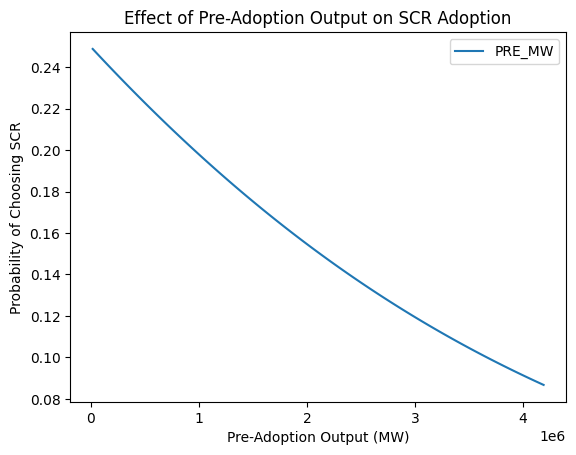

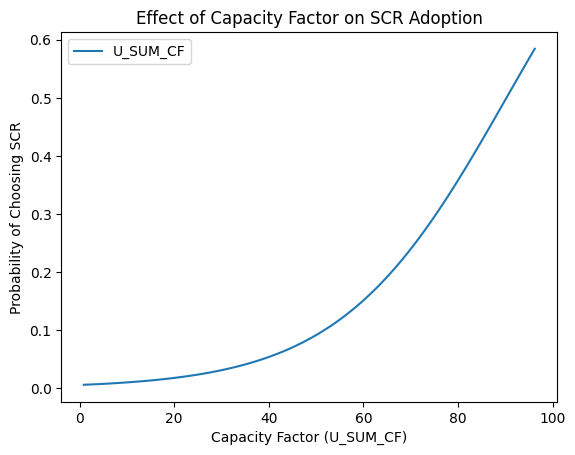

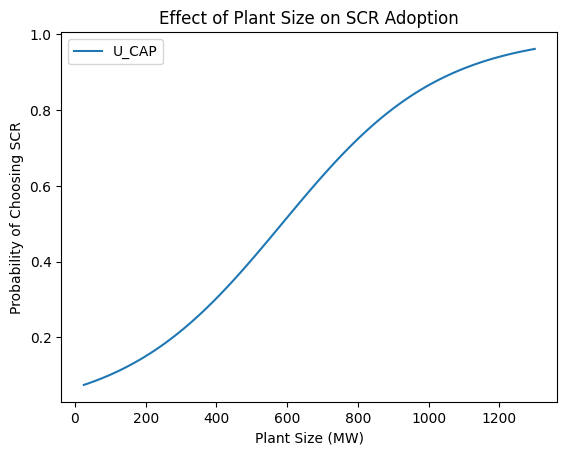

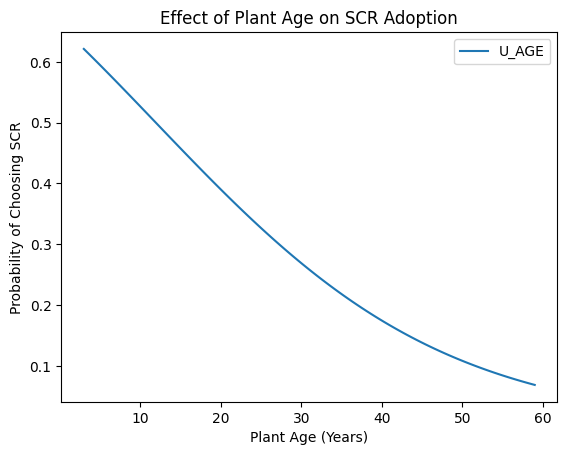

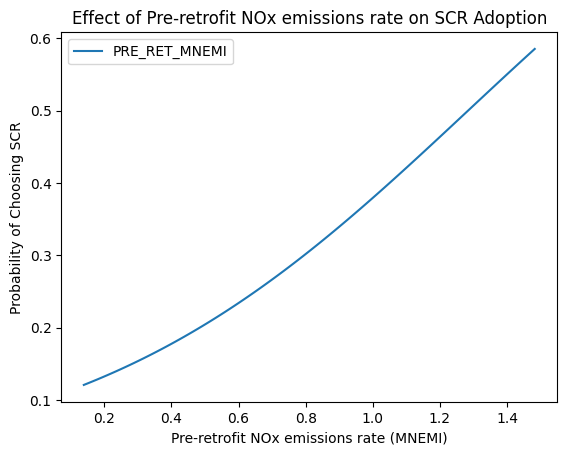

In [15]:
# Step 1: Load and Prepare the Data
data = pd.read_csv("https://raw.githubusercontent.com/fhc-smt/SMT/main/merged_data.csv")

# Create a binary dependent variable for SCR adoption (1 if SCR, 0 otherwise)
data['Binary_Choice'] = data['D_SCR']  # Assuming D_SCR is the dummy for SCR adoption

# Define Predictors: Pre-adoption output, capacity factor, plant size, and age
X = data[['PRE_MW', 'U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI']]  # Independent variables
y = data['Binary_Choice']  # Dependent variable

# Add a constant term for the intercept
X = sm.add_constant(X)

# Step 2: Estimate Logistic Regression
model = Logit(y, X)
result = model.fit()

# Step 3: Display Model Summary
print(result.summary())

# Step 4: Marginal Effects
# Calculate marginal effects to understand the influence of each predictor
marginal_effects = result.get_margeff()
print(marginal_effects.summary())

# Step 5: Visualization - Effect of Each Predictor on SCR Adoption Probability
# Define helper function to calculate probabilities for a range of values
def calculate_probabilities(variable, variable_name, fixed_values, model):
    values = np.linspace(data[variable_name].min(), data[variable_name].max(), 100)
    probabilities = []

    for value in values:
        predictors = fixed_values.copy()
        predictors[variable_name] = value
        pred = model.predict(pd.DataFrame(predictors, index=[0]))
        probabilities.append(pred.values[0])

    return values, probabilities

# Fixed values for predictors (hold others constant)
fixed_values = {
    'const': 1,
    'PRE_MW': data['PRE_MW'].mean(),
    'U_SUM_CF': data['U_SUM_CF'].mean(),
    'U_CAP': data['U_CAP'].mean(),
    'U_AGE': data['U_AGE'].mean(),
    'PRE_RET_MNEMI': data['PRE_RET_MNEMI'].mean() # Include the missing predictor
}

# Visualize Effect of Pre-Adoption Output (PRE_MW)
pre_mw_values, pre_mw_probabilities = calculate_probabilities('PRE_MW', 'PRE_MW', fixed_values, result)
plt.plot(pre_mw_values, pre_mw_probabilities, label='PRE_MW')
plt.xlabel('Pre-Adoption Output (MW)')
plt.ylabel('Probability of Choosing SCR')
plt.title('Effect of Pre-Adoption Output on SCR Adoption')
plt.legend()
plt.show()

# Visualize Effect of Capacity Factor (U_SUM_CF)
cf_values, cf_probabilities = calculate_probabilities('U_SUM_CF', 'U_SUM_CF', fixed_values, result)
plt.plot(cf_values, cf_probabilities, label='U_SUM_CF')
plt.xlabel('Capacity Factor (U_SUM_CF)')
plt.ylabel('Probability of Choosing SCR')
plt.title('Effect of Capacity Factor on SCR Adoption')
plt.legend()
plt.show()

# Visualize Effect of Plant Size (U_CAP)
cap_values, cap_probabilities = calculate_probabilities('U_CAP', 'U_CAP', fixed_values, result)
plt.plot(cap_values, cap_probabilities, label='U_CAP')
plt.xlabel('Plant Size (MW)')
plt.ylabel('Probability of Choosing SCR')
plt.title('Effect of Plant Size on SCR Adoption')
plt.legend()
plt.show()

# Visualize Effect of Plant Age (U_AGE)
age_values, age_probabilities = calculate_probabilities('U_AGE', 'U_AGE', fixed_values, result)
plt.plot(age_values, age_probabilities, label='U_AGE')
plt.xlabel('Plant Age (Years)')
plt.ylabel('Probability of Choosing SCR')
plt.title('Effect of Plant Age on SCR Adoption')
plt.legend()
plt.show()

# Visualize Effect of Pre-retrofit NOx emissions rate (PRE_RET_MNEMI)
noxe_values, noxe_probabilities = calculate_probabilities('PRE_RET_MNEMI', 'PRE_RET_MNEMI', fixed_values, result)
plt.plot(noxe_values, noxe_probabilities, label='PRE_RET_MNEMI')
plt.xlabel('Pre-retrofit NOx emissions rate (MNEMI)')
plt.ylabel('Probability of Choosing SCR')
plt.title('Effect of Pre-retrofit NOx emissions rate on SCR Adoption')
plt.legend()
plt.show()


In [16]:
# Get the number of rows
num_rows = data.shape[0]
print(f"Number of rows: {num_rows}")

Number of rows: 567


In [17]:
# Step 2: Segment the Data by Regime
deregulated_data = data[data['REGIME'] == 1]
regulated_data = data[data['REGIME'] == 2]
public_data = data[data['REGIME'] == 3]

# Define a function to train a logistic regression model and make predictions
def regime_analysis(subset, regime_name):
    print(f"Processing {regime_name} Regime...")

    # Predictors and dependent variable
    X = subset[['U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI']]
    y = subset['D_SCR']  # Binary outcome: 1 = SCR, 0 = No SCR

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # Train the logistic regression model
    model = Logit(y, X)
    result = model.fit()
    print(result.summary())

    # Make predictions
    subset['Predicted_Prob'] = result.predict(X)  # Predicted probabilities
    subset['Predicted_SCR'] = (subset['Predicted_Prob'] >= 0.5).astype(int)  # Binary predictions

    # Summarize predictions
    predicted_count = subset['Predicted_SCR'].sum()  # Count predicted SCR
    actual_count = subset['D_SCR'].sum()  # Count actual SCR

    print(f"\n{regime_name} Regime:")
    print(f"Predicted SCR Adoption: {predicted_count}")
    print(f"Actual SCR Adoption: {actual_count}")
    print(f"Prediction Accuracy: {(subset['Predicted_SCR'] == subset['D_SCR']).mean():.2%}")

    return subset

# Step 3: Perform Analysis for Each Regime
deregulated_results = regime_analysis(deregulated_data, "Deregulated")
regulated_results = regime_analysis(regulated_data, "Regulated")
public_results = regime_analysis(public_data, "Public")

# Step 4: Aggregate Results
total_predicted = deregulated_results['Predicted_SCR'].sum() + \
                  regulated_results['Predicted_SCR'].sum() + \
                  public_results['Predicted_SCR'].sum()
total_actual = data['D_SCR'].sum()

print(f"\nOverall Results:")
print(f"Total Predicted SCR Adoption: {total_predicted}")
print(f"Total Actual SCR Adoption: {total_actual}")

overall_accuracy = (
    (deregulated_results['Predicted_SCR'] == deregulated_results['D_SCR']).mean() +
    (regulated_results['Predicted_SCR'] == regulated_results['D_SCR']).mean() +
    (public_results['Predicted_SCR'] == public_results['D_SCR']).mean()
) / 3
print(f"Overall Prediction Accuracy: {overall_accuracy:.2%}")


Processing Deregulated Regime...
Optimization terminated successfully.
         Current function value: 0.313070
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  D_SCR   No. Observations:                  194
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                            4
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.2578
Time:                        16:16:48   Log-Likelihood:                -60.736
converged:                       True   LL-Null:                       -81.832
Covariance Type:            nonrobust   LLR p-value:                 1.522e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.7230      1.941     -1.918      0.055      -7.527

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12991/2145755520.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Predicted_Prob'] = result.predict(X)  # Predicted probabilities
/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12991/2145755520.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Predicted_SCR'] = (subset['Predicted_Prob'] >= 0.5).astype(int)  # Binary predictions
/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12991/2145755520.py:23: Setti

In [18]:
# Split data into training and testing sets
def split_data(data):
    return train_test_split(
        data, test_size=0.3, random_state=42, stratify=data['D_SCR']  # Stratify to maintain class balance
    )

# Define a function to train and evaluate the model for each regime
def train_and_evaluate(data, regime_name):
    # Split data into training and testing sets
    train_data, test_data = split_data(data)

    # Define predictors and dependent variable
    X_train = train_data[['U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI']]
    y_train = train_data['D_SCR']
    X_test = test_data[['U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI']]
    y_test = test_data['D_SCR']

    # Add a constant term for the intercept
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Train the logistic regression model
    model = Logit(y_train, X_train)
    result = model.fit()
    print(f"\n{regime_name} Regime Model Summary:")
    print(result.summary())

    # Predict on the test set
    test_data['Predicted_Prob'] = result.predict(X_test)
    test_data['Predicted_SCR'] = (test_data['Predicted_Prob'] >= 0.5).astype(int)

    # Evaluate performance
    from sklearn.metrics import classification_report, confusion_matrix
    print(f"\n{regime_name} Regime Test Set Performance:")
    print(confusion_matrix(y_test, test_data['Predicted_SCR']))
    print(classification_report(y_test, test_data['Predicted_SCR']))

    return test_data

# Apply this process for each regime
deregulated_results = train_and_evaluate(deregulated_data, "Deregulated")
regulated_results = train_and_evaluate(regulated_data, "Regulated")
public_results = train_and_evaluate(public_data, "Public")


Optimization terminated successfully.
         Current function value: 0.303905
         Iterations 7

Deregulated Regime Model Summary:
                           Logit Regression Results                           
Dep. Variable:                  D_SCR   No. Observations:                  135
Model:                          Logit   Df Residuals:                      130
Method:                           MLE   Df Model:                            4
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.2755
Time:                        16:16:48   Log-Likelihood:                -41.027
converged:                       True   LL-Null:                       -56.630
Covariance Type:            nonrobust   LLR p-value:                 2.779e-06
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.8164      2.390     -0.760      0.447      -6.5

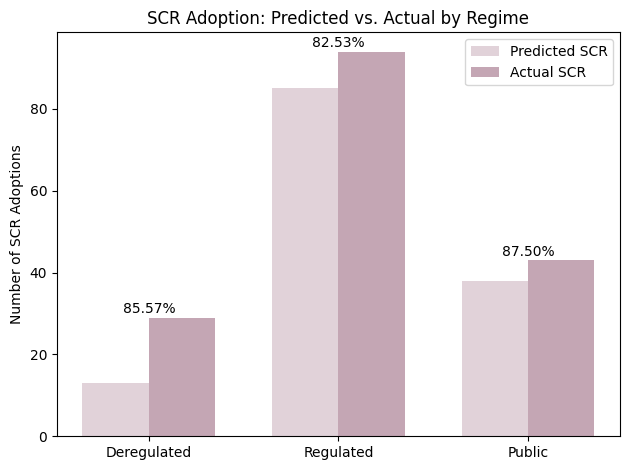

In [19]:
# Data for the regimes
regimes = ['Deregulated', 'Regulated', 'Public']
predicted_scr = [13, 85, 38]
actual_scr = [29, 94, 43]
accuracy = [85.57, 82.53, 87.5]

# Create bar chart
x = np.arange(len(regimes))  # the label locations
width = 0.35  # the width of the bars
actual_scr_color = '#c4a6b4'
predicted_scr_color = mcolors.to_rgba(actual_scr_color, alpha=0.5)

fig, ax1 = plt.subplots()

rects1 = ax1.bar(x - width/2, predicted_scr, width, label='Predicted SCR', color=predicted_scr_color)
rects2 = ax1.bar(x + width/2, actual_scr, width, label='Actual SCR', color=actual_scr_color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Number of SCR Adoptions')
ax1.set_title('SCR Adoption: Predicted vs. Actual by Regime')
ax1.set_xticks(x)
ax1.set_xticklabels(regimes)
ax1.legend()

# Add accuracy as text above bars
for i, v in enumerate(accuracy):
    ax1.text(x[i], max(predicted_scr[i], actual_scr[i]) + 1, f"{v:.2f}%", ha='center', color='black')

# Display the plot
plt.tight_layout()
plt.show()

In [23]:
# Check for missing values and handle them
data = data.dropna()  # Drop rows with missing values

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['D_SCR'])

# Define predictors explicitly, including the dummy variables for REGIME
X_train = train_data[['U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI', 'REG_x', 'PUB_x']]
X_test = test_data[['U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI', 'REG_x', 'PUB_x']]

# Define the dependent variable (D_SCR) for training and testing
y_train = train_data['D_SCR']
y_test = test_data['D_SCR']

# Ensure all columns are numeric
print(X_train.dtypes)  # Confirm all columns are numeric

# Train a logistic regression model
model = Logit(y_train, X_train)
result = model.fit()

# Print model summary
print(result.summary())

# Predict on the test set
test_data['Predicted_Prob'] = result.predict(X_test)
test_data['Predicted_SCR'] = (test_data['Predicted_Prob'] >= 0.5).astype(int)

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_data['Predicted_SCR']))
print("\nClassification Report:")
print(classification_report(y_test, test_data['Predicted_SCR']))


U_SUM_CF         float64
U_CAP            float64
U_AGE            float64
PRE_RET_MNEMI    float64
REG_x            float64
PUB_x            float64
dtype: object
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  D_SCR   No. Observations:                  394
Model:                          Logit   Df Residuals:                      388
Method:                           MLE   Df Model:                            5
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.3269
Time:                        16:17:34   Log-Likelihood:                -160.73
converged:                       True   LL-Null:                       -238.79
Covariance Type:            nonrobust   LLR p-value:                 6.668e-32
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------

In [24]:
# Check for missing values and handle them
data = data.dropna()  # Drop rows with missing values

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['D_SCR'])

# Define predictors explicitly, including the dummy variables for REGIME
X_train = train_data[['U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI' ]]
X_test = test_data[['U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI']]

# Define the dependent variable (D_SCR) for training and testing
y_train = train_data['D_SCR']
y_test = test_data['D_SCR']

# Ensure all columns are numeric
print(X_train.dtypes)  # Confirm all columns are numeric

# Train a logistic regression model
model = Logit(y_train, X_train)
result = model.fit()

# Print model summary
print(result.summary())

# Predict on the test set
test_data['Predicted_Prob'] = result.predict(X_test)
test_data['Predicted_SCR'] = (test_data['Predicted_Prob'] >= 0.5).astype(int)

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_data['Predicted_SCR']))
print("\nClassification Report:")
print(classification_report(y_test, test_data['Predicted_SCR']))


U_SUM_CF         float64
U_CAP            float64
U_AGE            float64
PRE_RET_MNEMI    float64
dtype: object
Optimization terminated successfully.
         Current function value: 0.421346
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  D_SCR   No. Observations:                  394
Model:                          Logit   Df Residuals:                      390
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.3048
Time:                        16:17:52   Log-Likelihood:                -166.01
converged:                       True   LL-Null:                       -238.79
Covariance Type:            nonrobust   LLR p-value:                 2.398e-31
                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

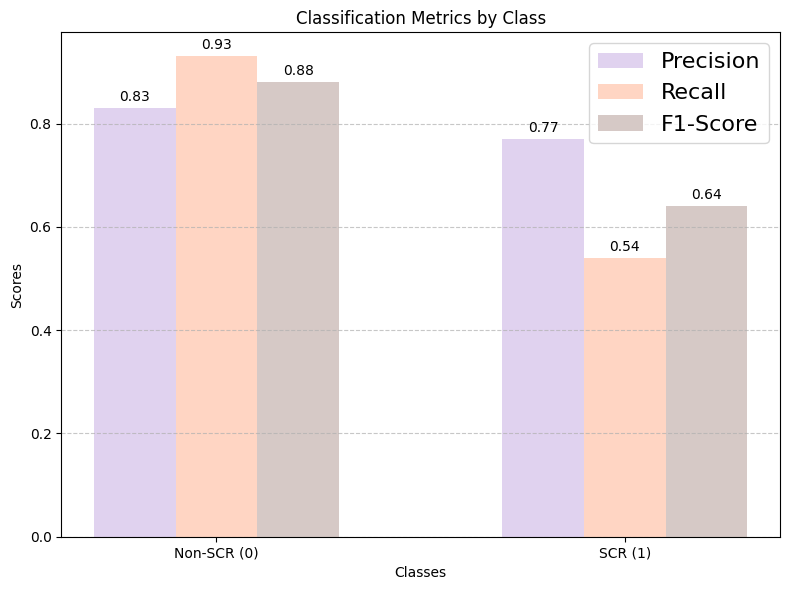

In [25]:
# Data for the chart
classes = ['Non-SCR (0)', 'SCR (1)']
precision = [0.83, 0.77]
recall = [0.93, 0.54]
f1_score = [0.88, 0.64]

# Create a grouped bar chart
x = np.arange(len(classes))  # Label locations
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(8, 6))

# Add bars for precision, recall, and F1-score
rects1 = ax.bar(x - width, precision, width, label='Precision', color='#e0d2ef')
rects2 = ax.bar(x, recall, width, label='Recall', color='#ffd5c3')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='#d6c9c6')

# Add labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend(fontsize=16)

# Function to add labels to bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to each bar group
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Show grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

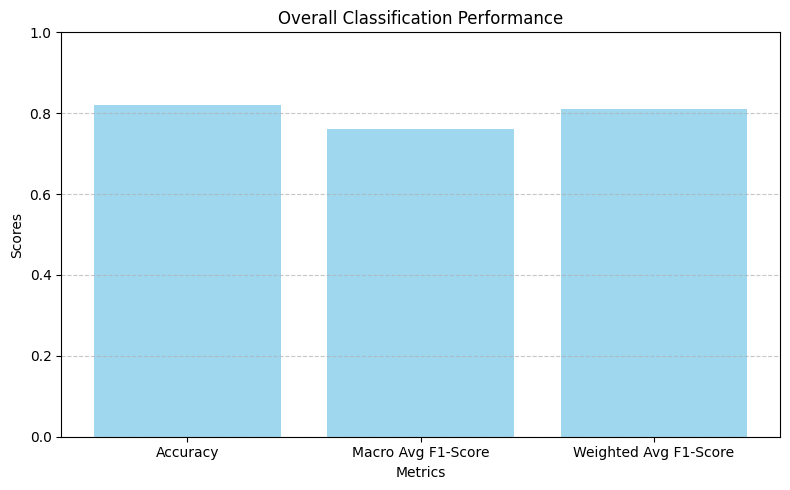

In [26]:
# Data for overall metrics
metrics = ['Accuracy', 'Macro Avg F1-Score', 'Weighted Avg F1-Score']
scores = [0.82, 0.76, 0.81]

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(metrics, scores, color='skyblue', alpha=0.8)

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Overall Classification Performance')
ax.set_ylim(0, 1)  # Ensure y-axis is consistent for percentages
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### If deregulated units received the same financial support as regulated and public units, would managers choose to adopt the most efficient NOx-reducing technology (SCR)?

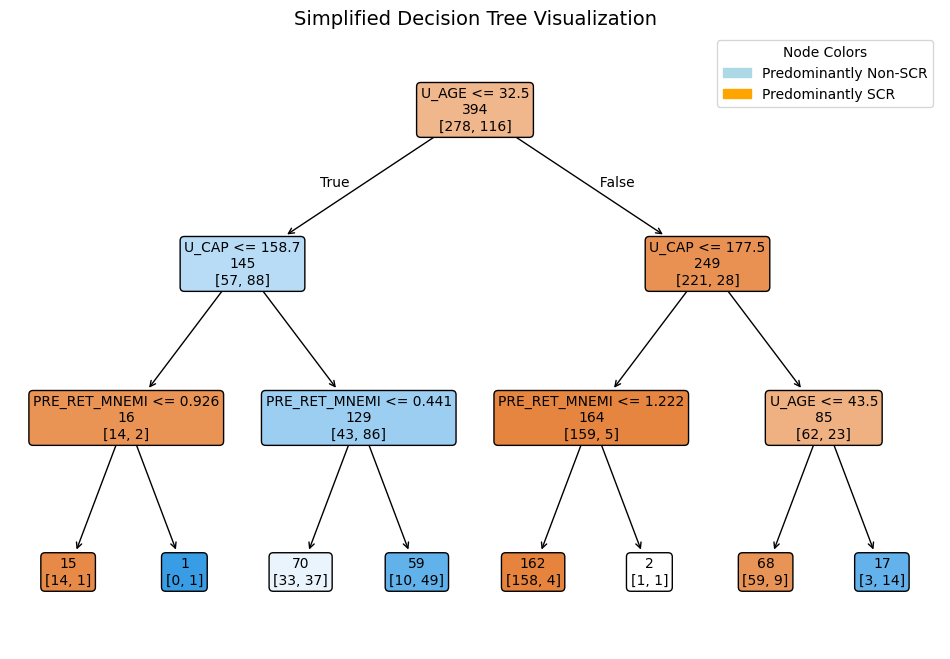

In [31]:
# Train a Decision Tree Classifier
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)  # Limit depth for better visualization
tree_model.fit(X_train, y_train)

# Create a simplified tree plot
plt.figure(figsize=(12, 8))
tree_plot = plot_tree(
    tree_model,
    feature_names=X_train.columns,
    class_names=None,  # Hide class names
    filled=True,
    rounded=True,
    fontsize=10,
    proportion=False,  # Disable proportional scaling of nodes
    impurity=False,  # Hide impurity (e.g., Gini or entropy)
    label='none'  # Hide sample sizes and class predictions
)

# Add a legend for colors
handles = [
    mpatches.Patch(color="lightblue", label="Predominantly Non-SCR"),
    mpatches.Patch(color="orange", label="Predominantly SCR")
]
plt.legend(handles=handles, loc="upper right", title="Node Colors", fontsize=10)

# Add a title for the plot
plt.title('Simplified Decision Tree Visualization', fontsize=14)
plt.show()


In [34]:
# Predict using the Decision Tree
tree_predictions = tree_model.predict(X_test)

# Evaluate Decision Tree
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, tree_predictions))
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, tree_predictions))
tree_accuracy = accuracy_score(y_test, tree_predictions)
print(f"Decision Tree Accuracy: {tree_accuracy:.2f}")

# Predict using Logistic Regression
logit_predictions = result.predict(X_test) >= 0.5  # Convert probabilities to binary outcomes

# Evaluate Logistic Regression
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, logit_predictions))
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, logit_predictions))
logit_accuracy = accuracy_score(y_test, logit_predictions)
print(f"Logistic Regression Accuracy: {logit_accuracy:.2f}")

# Compare Accuracies
if tree_accuracy > logit_accuracy:
    print("\nThe Decision Tree outperforms Logistic Regression.")
elif tree_accuracy < logit_accuracy:
    print("\nLogistic Regression outperforms the Decision Tree.")
else:
    print("\nBoth models have the same accuracy.")


Decision Tree Confusion Matrix:
[[100  19]
 [ 13  37]]

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       119
           1       0.66      0.74      0.70        50

    accuracy                           0.81       169
   macro avg       0.77      0.79      0.78       169
weighted avg       0.82      0.81      0.81       169

Decision Tree Accuracy: 0.81

Logistic Regression Confusion Matrix:
[[111   8]
 [ 22  28]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       119
           1       0.78      0.56      0.65        50

    accuracy                           0.82       169
   macro avg       0.81      0.75      0.77       169
weighted avg       0.82      0.82      0.81       169

Logistic Regression Accuracy: 0.82

Logistic Regression outperforms the Decision Tree.


This approach could indeed reveal the role of regulatory pressure and financial considerations in managerial decisions by comparing predictions based solely on plant characteristics with real-world behavior in deregulated units.
Conceptual Framework

    Training on Regulated and Public Units:
        Since these units face high regulatory pressure and less financial constraint, their decisions are more likely to reflect compliance with regulations rather than cost concerns.
        By training the model on data from Regulated and Public units, you're effectively building a decision framework that reflects plant characteristics under regulatory priorities.

    Testing on Deregulated Units:
        Deregulated units operate with less regulatory pressure and are likely more influenced by costs.
        Comparing the model's predictions (based on plant characteristics) to real-world choices allows you to test whether deregulated managers deviated from "expected" behavior because of cost considerations or other factors not captured by plant characteristics.

    Interpreting Results:
        If the model predicts that deregulated units should adopt SCR based on their characteristics but they do not in reality, it suggests that costs and financial constraints are the dominant factors in their decisions.
        Conversely, if the predictions align with real-world behavior, it implies that plant characteristics alone can largely explain the decision-making process.


In [35]:
# Filter data for Regulated and Public units (training data)
train_data = data[(data['REG_x'] == 1) | (data['PUB_x'] == 1)]

# Filter data for Deregulated units (testing data)
test_data = data[(data['REG_x'] == 0) & (data['PUB_x'] == 0)]

# Define predictors and target
X_train = train_data[['U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI']]
y_train = train_data['D_SCR']

X_test = test_data[['U_SUM_CF', 'U_CAP', 'U_AGE', 'PRE_RET_MNEMI']]
y_test = test_data['D_SCR']

In [36]:
# Train logistic regression model
model = Logit(y_train, X_train)
result = model.fit()

# Predict on Deregulated units
test_data['Predicted_Prob'] = result.predict(X_test)
test_data['Predicted_SCR'] = (test_data['Predicted_Prob'] >= 0.5).astype(int)

# Evaluate the predictions
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_data['Predicted_SCR']))
print("\nClassification Report:")
print(classification_report(y_test, test_data['Predicted_SCR']))

Optimization terminated successfully.
         Current function value: 0.452727
         Iterations 6
Confusion Matrix:
[[139  23]
 [  9  20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       162
           1       0.47      0.69      0.56        29

    accuracy                           0.83       191
   macro avg       0.70      0.77      0.73       191
weighted avg       0.87      0.83      0.84       191



/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12991/838756995.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Prob'] = result.predict(X_test)
/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12991/838756995.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SCR'] = (test_data['Predicted_Prob'] >= 0.5).astype(int)


In [37]:
# Count actual SCR and Non-SCR in deregulated units
actual_counts = y_test.value_counts()  # Count 1 (SCR) and 0 (Non-SCR)

# Count predicted SCR and Non-SCR in deregulated units
predicted_counts = test_data['Predicted_SCR'].value_counts()  # Count 1 (SCR) and 0 (Non-SCR)

# Combine into a DataFrame for easier comparison
comparison_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
}).fillna(0)  # Fill missing values with 0 if a category is absent

# Calculate percentages
comparison_df['Actual_Percentage'] = comparison_df['Actual'] / comparison_df['Actual'].sum() * 100
comparison_df['Predicted_Percentage'] = comparison_df['Predicted'] / comparison_df['Predicted'].sum() * 100

# Display the comparison
print("Comparison of Actual and Predicted SCR Adoption in Deregulated Units:")
print(comparison_df)


Comparison of Actual and Predicted SCR Adoption in Deregulated Units:
   Actual  Predicted  Actual_Percentage  Predicted_Percentage
0     162        148          84.816754             77.486911
1      29         43          15.183246             22.513089


If Predicted SCR > Actual SCR:

    The model overestimates SCR adoption.
    This suggests that costs or regulatory pressures, which are absent in your model, play a significant role in real-world decisions.

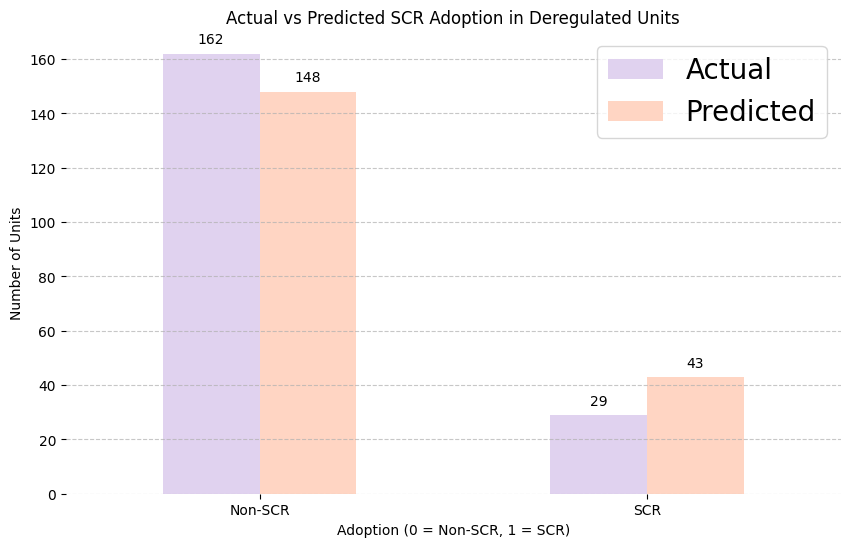

In [41]:
# Bar chart for comparison
ax = comparison_df[['Actual', 'Predicted']].plot(
    kind='bar',
    figsize=(10, 6),
    color=['#e0d2ef', mcolors.to_rgba('#ffd5c3')] # Add '#' before color codes
)

plt.title('Actual vs Predicted SCR Adoption in Deregulated Units')
plt.xlabel('Adoption (0 = Non-SCR, 1 = SCR)')
plt.ylabel('Number of Units')
plt.xticks(ticks=[0, 1], labels=['Non-SCR', 'SCR'], rotation=0)
plt.legend(['Actual', 'Predicted'], fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove border (spines)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)


# Add numbers above bars
for p in ax.patches:
    ax.annotate(
        str(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),  # Adjust vertical offset if needed
        textcoords='offset points'
    )

plt.show()

In [39]:
# Define the columns to summarize
variables = {
    "UNIT_ID": "Number of Units",
    "U_CAP": "Capacity (MW)",
    "U_AGE": "Unit Age (Years)",
    "PRE_RET_MNEMI": "Pre-retrofit NOx Emissions (lbs/mmBtu)",
    "U_SUM_CF": "Pre-retrofit Summer Capacity Factor (%)"
}


# Group by 'Regime' and calculate mean and standard deviation for each variable
summary = data.groupby("REGIME").agg(
    {var: [("mean", "mean"), ("std", "std")] for var in variables.keys()}
)

# Flatten multi-level columns for cleaner presentation
summary.columns = [' '.join(col).strip() for col in summary.columns]

# Create a readable summary table
summary_table = summary.reset_index()
for var, label in variables.items():
    summary_table[label] = summary_table[f"{var} mean"].round(2).astype(str) + " (" + summary_table[f"{var} std"].round(2).astype(str) + ")"

# Select only the final formatted columns
final_table = summary_table[["REGIME"] + list(variables.values())]

# Display or save the summary table
print(final_table)



   REGIME Number of Units    Capacity (MW) Unit Age (Years)  \
0       1     2.15 (1.29)  265.53 (211.56)     37.85 (9.55)   
1       2       2.3 (1.3)  331.65 (280.25)    34.76 (11.29)   
2       3     3.19 (2.41)  225.68 (230.37)     35.9 (10.12)   

  Pre-retrofit NOx Emissions (lbs/mmBtu)  \
0                            0.47 (0.21)   
1                            0.54 (0.22)   
2                            0.56 (0.23)   

  Pre-retrofit Summer Capacity Factor (%)  
0                           64.47 (15.06)  
1                           68.15 (14.13)  
2                           68.99 (11.74)  


In [40]:
import pandas as pd

# Count the frequency of values in the 'Regime' column
regime_counts = data['REGIME'].value_counts().reset_index()

# Rename columns for better readability
regime_counts.columns = ['Regime', 'Frequency']

# Display the result
print(regime_counts)



   Regime  Frequency
0       2        269
1       1        191
2       3        103



## Effect of NBP on NOx emissions of a unit
__Did NBP units really reduce their NOx emissions overall compared to non NBP units?__

Your extension—investigating whether the NOx Budget Program (NBP) was successful overall by examining its impact on NOx emissions using an OLS framework—is a valid and meaningful addition to the literature. The original paper by Fowlie focused on compliance choices under different regulatory regimes, which is a micro-level analysis of how market regulation shapes behavior. Your extension takes a complementary macro-level perspective, looking at the overall environmental effectiveness of the program in reducing NOx emissions.
Motivation for Your Extension

Policy Evaluation Beyond Compliance Choices:
While Fowlie’s analysis of compliance choices helps us understand how regulations influence behavior, the ultimate goal of such programs is to reduce emissions. By directly assessing the impact of NBP on emissions, your work evaluates whether the program achieved its primary objective.

Public Policy Relevance:
Policymakers and stakeholders need evidence of program effectiveness to justify past policies and guide future decisions. Your analysis addresses this need by providing empirical evidence on whether the NBP delivered tangible environmental benefits.

Broadening the Scope:
Fowlie’s paper focuses on the interaction of regulation and market dynamics. By shifting the focus to overall program effectiveness, you address a different but equally important research question: Does participation in market-based programs like the NBP result in measurable emissions reductions at a macro level?

Strengths of Your Approach

Inclusion of Key Covariates:
Your model includes essential factors influencing emissions, such as heat input (a proxy for energy production), gross load, and population. These variables control for changes in emissions driven by energy demand, technological changes, and demographic shifts.

Quantifying NBP’s Effectiveness:
The use of a dummy variable for NBP participation isolates the program's impact on emissions, providing a clear measure of its effectiveness.

Integration of ARP:
By including an ARP dummy, your model accounts for overlapping regulatory influences, ensuring that the estimated effect of NBP is not confounded by concurrent programs.

Suggestions for Improvement or Extensions

Regulatory Regime Interaction:
Consider segmenting your analysis by regulatory regimes (regulated, deregulated, and public units). This segmentation aligns your work more closely with Fowlie’s framework and allows you to explore whether NBP’s effectiveness varies by regulatory environment.

Temporal Effects:
Add interaction terms for NBP_Dummy and Year_Trend to capture whether NBP’s impact on emissions strengthened or weakened over time. This could reveal whether compliance costs or technological adoption played a role in the program's evolving effectiveness.

Inclusion of Unit Characteristics:
If data is available, include unit-level variables such as fuel type, technology type, and control technologies (e.g., SCR, SNCR). These characteristics directly influence emissions and could strengthen your model’s explanatory power.

Spatial Effects:
Explore spatial spillover effects by incorporating regional or state-level fixed effects. This addition would control for regional policies, economic conditions, or geographic factors influencing emissions.

Heterogeneous Treatment Effects:
Investigate whether NBP’s impact differs for specific types of facilities (e.g., size, ownership type, baseline emissions levels). This analysis could uncover insights into which facilities benefited most from the program.

Robustness Checks:
Test your results under different specifications (e.g., alternative functional forms, dropping outliers, using alternative measures of program participation). Robustness checks strengthen the validity of your findings.

Counterfactual Analysis:
If feasible, incorporate a difference-in-differences approach to compare emissions trends between participating and non-participating units before and after the program's implementation.

Conclusion

Your extension is well-motivated and fills an important gap in the literature by evaluating the environmental effectiveness of the NBP. However, incorporating the suggestions above could significantly enhance the depth and robustness of your analysis. By extending your model to account for regulatory regimes, temporal dynamics, unit characteristics, and spatial effects, you would generate richer insights and a more comprehensive evaluation of the NBP’s success. Let me know if you'd like help implementing any of these ideas!

In [17]:
facilities = pd.read_csv(url+"facilities.csv")

In [18]:
pop2000_2010 = pd.read_csv(url+'pop_2000_2010.csv')
pop2000_2009 = pop2000_2010[pop2000_2010['Year']!=2010]

In [ ]:
pop2010_2015=pd.read_csv(url+'pop_2010_2015.csv')
pop2010_2015

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,Year,Population
0,40,3,6,1,0,Alabama,Alabama,2010,4785437
1,50,3,6,1,1,Alabama,Autauga County,2010,54773
2,50,3,6,1,3,Alabama,Baldwin County,2010,183112
3,50,3,6,1,5,Alabama,Barbour County,2010,27327
4,50,3,6,1,7,Alabama,Bibb County,2010,22870
...,...,...,...,...,...,...,...,...,...
19153,50,4,8,56,37,Wyoming,Sweetwater County,2015,44719
19154,50,4,8,56,39,Wyoming,Teton County,2015,23047
19155,50,4,8,56,41,Wyoming,Uinta County,2015,20763
19156,50,4,8,56,43,Wyoming,Washakie County,2015,8278


In [20]:
pop = pd.concat([pop2000_2009, pop2010_2015], ignore_index=True)

In [21]:
state_abbreviation_to_number = {
    'AL': 1, 'AK': 2, 'AZ': 4, 'AR': 5, 'CA': 6, 'CO': 8, 'CT': 9, 
    'DE': 10, 'FL': 12, 'GA': 13, 'HI': 15, 'ID': 16, 'IL': 17, 
    'IN': 18, 'IA': 19, 'KS': 20, 'KY': 21, 'LA': 22, 'ME': 23, 
    'MD': 24, 'MA': 25, 'MI': 26, 'MN': 27, 'MS': 28, 'MO': 29, 
    'MT': 30, 'NE': 31, 'NV': 32, 'NH': 33, 'NJ': 34, 'NM': 35, 
    'NY': 36, 'NC': 37, 'ND': 38, 'OH': 39, 'OK': 40, 'OR': 41, 
    'PA': 42, 'RI': 44, 'SC': 45, 'SD': 46, 'TN': 47, 'TX': 48, 
    'UT': 49, 'VT': 50, 'VA': 51, 'WA': 53, 'WV': 54, 'WI': 55, 
    'WY': 56, 'DC': 11
}
facilities['STATE']= facilities['State'].map(state_abbreviation_to_number)
facilities.rename(columns={'FIPS Code':'COUNTY'},inplace=True)
facilities['STATE']=facilities['STATE'].fillna(-1)
facilities['STATE']=facilities['STATE'].astype(int)

In [ ]:
fac_with_pop = pd.merge(
    facilities,
    pop,
    left_on=['STATE', 'COUNTY','County','Year'],
    right_on=['STATE', 'COUNTY','CTYNAME','Year'],
    how='left'  #retain all rows in facilities
)
fac_with_pop

,State,Facility Name,Facility ID,Unit ID,Associated Stacks,Year,Program Code,Primary Rep Info,EPA Region,NERC Region,County,County Code,COUNTY,Source Category,Latitude,Longitude,Owner/Operator,SO2 Phase,NOx Phase,Unit Type,Primary Fuel Type,Secondary Fuel Type,SO2 Controls,NOx Controls,PM Controls,Hg Controls,Commercial Operation Date,Operating Status,Max Hourly HI Rate (mmBtu/hr),Associated Generators & Nameplate Capacity (MWe),STATE,SUMLEV,REGION,DIVISION,STNAME,CTYNAME,Population
0,AL,Barry,3,1,CS0AAN,1996,ARP,83,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,Barry,3,1,CS0AAN,1997,ARP,"83 (Ended Dec 07, 1997), 900 (Started Dec 08, ...",4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
2,AL,Barry,3,1,CS0AAN,1998,ARP,"900 (Ended May 26, 1998), 975 (Started May 27,...",4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
3,AL,Barry,3,1,CS0AAN,1999,ARP,975,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
4,AL,Barry,3,1,CS0AAN,2000,ARP,975,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,Alabama Power Company (Operator),Phase 2,Phase 2 Group 1,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,50.0,3.0,6.0,Alabama,Mobile County,400073.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21225,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2013,"ARP, CAIRNOX, CAIROS, CAIRSO2","603957 (Ended Jun 28, 2013), 606670 (Started J...",3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51,50.0,3.0,5.0,Virginia,Wise County,40662.0
21226,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2014,"ARP, CAIRNOX, CAIROS, CAIRSO2",606670,3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51,50.0,3.0,5.0,Virginia,Wise County,39892.0
21227,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2015,"ARP, CSNOX, CSNOXOS, CSSO2G1, MATS","606670 (Ended Mar 26, 2015), 607952 (Started J...",3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51,50.0,3.0,5.0,Virginia,Wise County,39572.0
21228,PR,"AES Puerto Rico, LP",880102,1,NaN,2015,MATS,"607769 (Started Feb 04, 2015)",2,NaN,Guayama Municipio,PR057,57,Electric Utility,17.9477,-66.1540,"AES Puerto Rico (Owner) (Started Feb 04, 2015)...",NaN,NaN,Circulating fluidized bed boiler,Coal,NaN,Dry Lime FGD,Selective Non-catalytic Reduction,Electrostatic Precipitator,NaN,2002-11-29,Operating,2461.0,1 (260)

In [ ]:
emissions_with_pop = pd.merge(
    fac_with_pop[['State','County','Facility Name','Facility ID','Unit ID','Year','Source Category','Population']],
    emissions,
    left_on=['State','Facility Name','Facility ID','Unit ID','Year'],
    right_on=['State','Facility Name','Facility ID','Unit ID','Year'],
    how='right'
)
emissions_with_pop['Program Code'] = emissions_with_pop['Program Code'].fillna('')
emissions_with_pop['NBP_Dummy']=emissions_with_pop['Program Code'].str.contains('NBP').astype(int)
emissions_with_pop['ARP_Dummy'] = emissions_with_pop['Program Code'].str.contains('ARP').astype(int)
emissions_with_pop = emissions_with_pop[['Facility ID','Facility Name', 'Unit ID','Year','State','County', 'Program Code', 'NBP_Dummy','NOx Controls', 
    'ARP_Dummy', 'NOx Mass (short tons)', 
    'Heat Input (mmBtu)', 'Gross Load (MWh)','Population']]
emissions_with_pop['NOx Controls']=emissions_with_pop['NOx Controls'].fillna('')
emissions_with_pop.dropna(inplace=True)
emissions_with_pop

,Facility ID,Facility Name,Unit ID,Year,State,County,Program Code,NBP_Dummy,NOx Controls,ARP_Dummy,NOx Mass (short tons),Heat Input (mmBtu),Gross Load (MWh),Population
3,3,Barry,1,2000,AL,Mobile County,ARP,0,,1,1047.781,4.470517e+06,443298.00,400073.0
4,3,Barry,1,2001,AL,Mobile County,ARP,0,,1,1069.962,4.471720e+06,449501.75,400129.0
5,3,Barry,1,2002,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OF...,1,1002.106,3.802079e+06,361992.25,398549.0
6,3,Barry,1,2003,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OFA,1,941.739,4.386719e+06,436529.25,398082.0
7,3,Barry,1,2004,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OFA,1,671.391,3.664495e+06,369265.00,397959.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22573,56611,Sandy Creek Energy Station,S01,2015,TX,McLennan County,"ARP, CSNOX, CSNOXOS, CSSO2G2, MATS",0,Selective Catalytic Reduction,1,441.695,2.142731e+07,2110877.75,245444.0
22574,56671,Longview Power,001,2012,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,508.219,1.516370e+07,1845010.27,100915.0
22575,56671,Longview Power,001,2013,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,457.459,1.482523e+07,1762061.93,102266.0
22576,56671,Longview Power,001,2014,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,408.181,1.262892e+07,1411811.86,103480.0


In [24]:
choices=emissions_with_pop[emissions_with_pop['NBP_Dummy']==1]['NOx Controls'].unique()
emissions_with_pop['CM']=emissions_with_pop['NOx Controls'].str.contains('Combustion Modification').astype(int)
emissions_with_pop['SNCR']=emissions_with_pop['NOx Controls'].str.contains('Selective Non-catalytic Reduction').astype(int)
emissions_with_pop['LN']=emissions_with_pop['NOx Controls'].str.contains('Low NOx Burner').astype(int)
emissions_with_pop['SCR']=emissions_with_pop['NOx Controls'].str.contains('Selective Catalytic Reduction ').astype(int)
emissions_with_pop['None']=(emissions_with_pop['NOx Controls']=='').astype(int)
emissions_with_pop['Adoption'] = 1-emissions_with_pop['None']

<Axes: title={'center': 'Number of units with no NOx Controls over the years'}, xlabel='Year'>

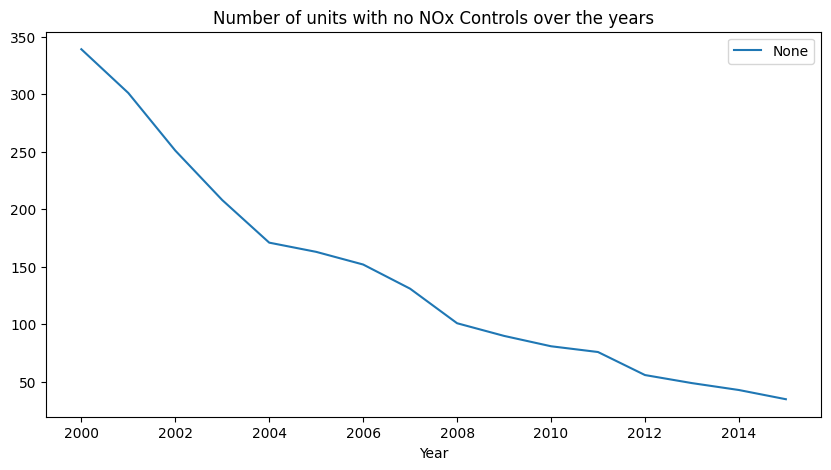

In [ ]:
distribution = emissions_with_pop.groupby('Year').sum().reset_index()#['None','SNCR','CM','LN','SCR'].sum().reset_index()
distribution=distribution[['Year','None','SNCR','CM','LN','SCR']]
distribution.plot.line(x='Year',y='None',title='Number of units with no NOx Controls over the years',figsize=(10,5))#=distribution.groupby('Year')['None','SNCR','CM']

<Axes: title={'center': 'NOx emissions over the years'}, xlabel='Year'>

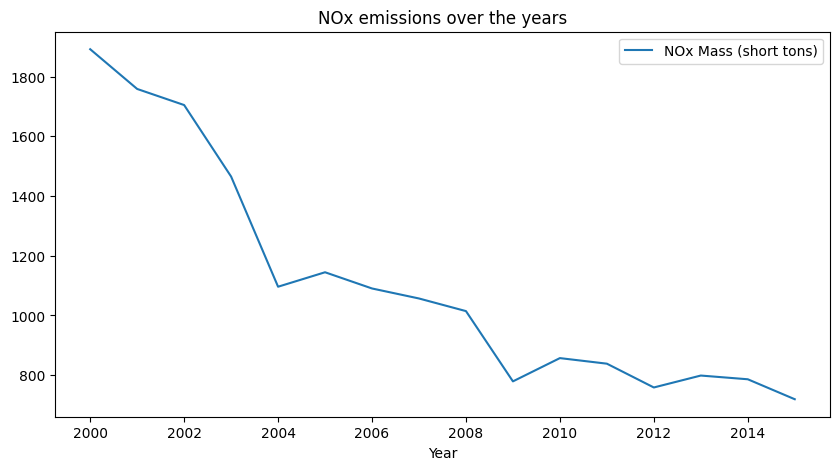

In [26]:
NOx_trend = emissions_with_pop.groupby('Year')['NOx Mass (short tons)'].mean().reset_index()
NOx_trend.plot.line(x='Year',y='NOx Mass (short tons)',title='NOx emissions over the years',figsize=(10,5))

<Axes: title={'center': 'Relationship between number of units adopting NOx Controls and NOx emissions'}, xlabel='None', ylabel='NOx Mass (short tons)'>

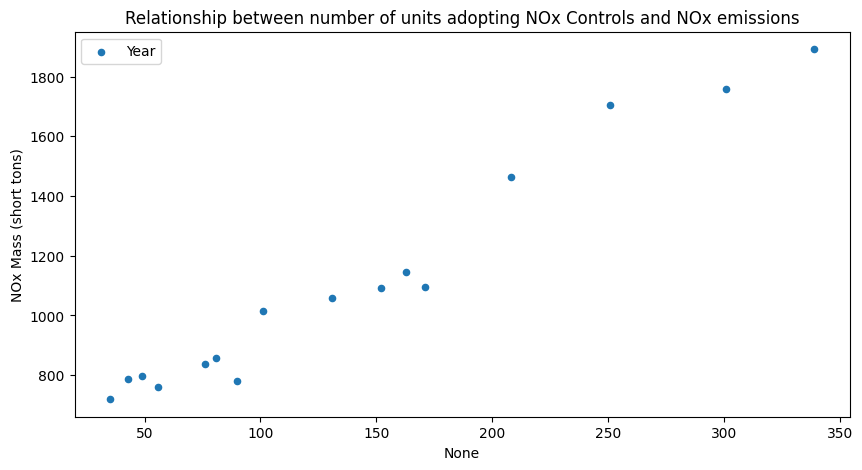

In [ ]:
NOx_vs_NBP=NOx_trend
NOx_vs_NBP['None']=emissions_with_pop.groupby('Year')['None'].sum().reset_index()['None']
#NOx_vs_NBP.plot.line(x='Year',y='NBP Units',title='Number of units adopting NOx Controls over the years',figsize=(10,5))
NOx_vs_NBP.plot.scatter(x='None',y='NOx Mass (short tons)',label='Year',title='Relationship between number of units adopting NOx Controls and NOx emissions',figsize=(10,5))

In [28]:
emissions_with_pop.groupby(['Facility ID','Unit ID']).size()

Facility ID  Unit ID
3            1          15
             2          15
             3          15
             4          16
             5          16
                        ..
56564        SN-01       3
56596        001         6
56609        01          5
56611        S01         3
56671        001         4
Length: 1057, dtype: int64

In [29]:
emissions_with_pop

,Facility ID,Facility Name,Unit ID,Year,State,County,Program Code,NBP_Dummy,NOx Controls,ARP_Dummy,NOx Mass (short tons),Heat Input (mmBtu),Gross Load (MWh),Population,CM,SNCR,LN,SCR,None,Adoption
3,3,Barry,1,2000,AL,Mobile County,ARP,0,,1,1047.781,4.470517e+06,443298.00,400073.0,0,0,0,0,1,0
4,3,Barry,1,2001,AL,Mobile County,ARP,0,,1,1069.962,4.471720e+06,449501.75,400129.0,0,0,0,0,1,0
5,3,Barry,1,2002,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OF...,1,1002.106,3.802079e+06,361992.25,398549.0,0,0,1,0,0,1
6,3,Barry,1,2003,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OFA,1,941.739,4.386719e+06,436529.25,398082.0,0,0,1,0,0,1
7,3,Barry,1,2004,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OFA,1,671.391,3.664495e+06,369265.00,397959.0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22573,56611,Sandy Creek Energy Station,S01,2015,TX,McLennan County,"ARP, CSNOX, CSNOXOS, CSSO2G2, MATS",0,Selective Catalytic Reduction,1,441.695,2.142731e+07,2110877.75,245444.0,0,0,0,0,0,1
22574,56671,Longview Power,001,2012,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,508.219,1.516370e+07,1845010.27,100915.0,0,0,1,0,0,1
22575,56671,Longview Power,001,2013,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,457.459,1.482523e+07,1762061.93,102266.0,0,0,1,0,0,1
22576,56671,Longview Power,001,2014,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,408.181,1.262892e+07,1411811.86,103480.0,0,0,1,0,0,1


In [30]:
emissions_with_pop['Population (in thousands)']=emissions_with_pop['Population']/1000

### DiD

In [31]:
NBP=emissions_with_pop[emissions_with_pop['NBP_Dummy']==1]
NBP['Year'].min()
emissions_with_pop['post']=(emissions_with_pop['Year'] >= NBP['Year'].min()).astype(int)

In [ ]:
import statsmodels.formula.api as smf

emissions_with_pop['NBP_Post'] = emissions_with_pop['NBP_Dummy'] * emissions_with_pop['post']
emissions_with_pop['ARP_Post'] = emissions_with_pop['ARP_Dummy'] * emissions_with_pop['post']
emissions_with_pop['NBP_ARP'] = emissions_with_pop['NBP_Dummy']*emissions_with_pop['ARP_Dummy']
NOx_data = emissions_with_pop
NOx_data['Facility_Unit_IDs'] = NOx_data['Facility ID'].astype(str) + '_' + NOx_data['Unit ID'].astype(str)
NOx_data = NOx_data.set_index(['Facility_Unit_IDs','Year'])

y_DiD = NOx_data['NOx Mass (short tons)']
X_DiD = NOx_data[['ARP_Dummy', 'NBP_Dummy','ARP_Post','Adoption', 
                         'Heat Input (mmBtu)', 'Gross Load (MWh)', 'Population (in thousands)']]
X_DiD=sm.add_constant(X_DiD)
# Add time fixed effects
model_DiD = PanelOLS(y_DiD, X_DiD, entity_effects=True, time_effects=True)

# Fit the model
results_DiD = model_DiD.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_DiD.summary)


                            PanelOLS Estimation Summary                            
Dep. Variable:     NOx Mass (short tons)   R-squared:                        0.1181
Estimator:                      PanelOLS   R-squared (Between):              0.5562
No. Observations:                  14603   R-squared (Within):               0.2709
Date:                   Tue, Jan 28 2025   R-squared (Overall):              0.4637
Time:                           15:59:46   Log-likelihood                -1.152e+05
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      258.77
Entities:                           1057   P-value                           0.0000
Avg Obs:                          13.816   Distribution:                 F(7,13524)
Min Obs:                          1.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

In [33]:
X0=NOx_data[['NBP_Dummy','Adoption']]
X0=sm.add_constant(X0)
model0=PanelOLS(y_DiD, X0, entity_effects=True, time_effects=True)
results0 = model0.fit(cov_type='clustered', cluster_entity=True)

X1=NOx_data[['NBP_Dummy','Adoption','Heat Input (mmBtu)','Gross Load (MWh)']]
X1=sm.add_constant(X1)
model1=PanelOLS(y_DiD, X1, entity_effects=True, time_effects=True)
results1 = model1.fit(cov_type='clustered', cluster_entity=True)

X2=NOx_data[['NBP_Dummy','Adoption','Heat Input (mmBtu)','Gross Load (MWh)','Population (in thousands)']]
X2=sm.add_constant(X2)
model2=PanelOLS(y_DiD, X2, entity_effects=True, time_effects=True)
results2 = model2.fit(cov_type='clustered', cluster_entity=True)


In [ ]:
print(results0.summary)
print(results1.summary)
print(results2.summary)
print(results_DiD.summary)


                            PanelOLS Estimation Summary                            
Dep. Variable:     NOx Mass (short tons)   R-squared:                        0.0296
Estimator:                      PanelOLS   R-squared (Between):             -0.0337
No. Observations:                  14603   R-squared (Within):               0.0153
Date:                   Tue, Jan 28 2025   R-squared (Overall):              0.0068
Time:                           15:59:46   Log-likelihood                -1.159e+05
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      206.17
Entities:                           1057   P-value                           0.0000
Avg Obs:                          13.816   Distribution:                 F(2,13529)
Min Obs:                          1.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

In [35]:
models = {"Model 1": results0, "Model 2": results1, "Model 3": results2,'Model 4':results_DiD}

# Extract coefficients, standard errors, and R-squared
comparison_table = pd.DataFrame()

for model_name, result in models.items():
     # Extract coefficients and standard errors
    coeffs = result.params
    std_errs = result.std_errors
    r_squared = result.rsquared

    # Combine coefficients and standard errors (e.g., "coef (std err)")
    formatted_results = coeffs.map('{:.3f}'.format) + " (" + std_errs.map('{:.3f}'.format) + ")"
    
    # Add R-squared separately as a row
    formatted_results["R-squared"] = f"{r_squared:.3f}"

    # Align variables across models (fill missing ones with NaN)
    comparison_table[model_name] = formatted_results

# Transpose for better presentation
comparison_table = comparison_table.T

# Display the comparison table
print(comparison_table)

                     const          NBP_Dummy           Adoption R-squared
Model 1  1464.778 (77.011)  -428.127 (39.989)  -277.805 (92.150)     0.030
Model 2   594.763 (89.187)  -381.864 (38.170)  -316.592 (87.158)     0.117
Model 3  505.947 (144.337)  -383.466 (38.201)  -312.980 (87.446)     0.118
Model 4  753.403 (341.237)  -385.701 (38.279)  -311.307 (87.476)     0.118


The presented results offer valuable insights that complement and extend the findings of Fowlie’s analysis. Fowlie's paper examines the effects of market regulation and program design, particularly the NOx Budget Program (NBP), on compliance choices and emissions reductions, with an emphasis on the role of market incentives and technology adoption in shaping regulatory outcomes. The inclusion of the NBP_Retrofit variable in the current model directly relates to her emphasis on the importance of compliance technologies in achieving emissions reductions under the NBP.

The results indicate that units participating in the NBP experienced a modest reduction in NOx emissions, as evidenced by the NBP_Dummy coefficient (-13.8889, p = 0.083). While this reduction is smaller and less statistically robust compared to Fowlie's findings, the addition of the NBP_Retrofit variable (-232.3398, p < 0.001) highlights a critical mechanism that Fowlie discusses extensively: the heterogeneity in compliance choices among regulated units. Fowlie argues that the flexibility afforded by market-based programs like the NBP enables units to adopt compliance strategies tailored to their specific cost structures and technological capabilities. The strong negative coefficient on NBP_Retrofit supports this argument, indicating that emissions reductions were driven largely by units that implemented specific retrofitting technologies.

The role of the ARP (Acid Rain Program) in shaping emissions outcomes is also consistent with Fowlie’s findings. The significant and positive coefficient for ARP_Dummy (1102.3243, p < 0.001) aligns with her characterization of ARP-regulated units as large, high-emission sources, often coal-fired power plants, which were major contributors to baseline NOx emissions. The significant reduction captured by ARP_Post (-912.5526, p < 0.001) confirms Fowlie’s conclusion that the ARP successfully incentivized substantial emissions reductions through stringent caps and allowances. The juxtaposition of the ARP’s strong, uniform reductions and the NBP’s more modest effects reinforces her point that differences in program design influence regulatory outcomes.

Additionally, the negative association between Population and NOx emissions (-0.0001, p < 0.001) can be interpreted through the lens of Fowlie’s discussion of political and public pressure. She notes that public scrutiny and local political considerations often shape compliance behavior. The results suggest that units located in more populous areas may face stronger incentives to reduce emissions due to regulatory oversight or the threat of public opposition.

The model’s overall explanatory power (R-squared = 0.507) is lower than Fowlie’s conditional logit models focused on compliance choices, which achieve greater precision due to their explicit modeling of the determinants of technology adoption. However, the broader scope of the current model, which seeks to directly estimate the effect of NBP participation on emissions outcomes while controlling for ARP, technology adoption, and demographic factors, provides a complementary perspective to her analysis.

In conclusion, these results reinforce and extend Fowlie’s conclusions by explicitly quantifying the role of compliance technologies in driving emissions reductions under the NBP. They affirm her argument that market-based regulation is effective in reducing pollution but that outcomes depend critically on technology adoption and other contextual factors. The findings also highlight the contrasting regulatory impacts of the NBP and ARP, consistent with her observations about the importance of program design in achieving environmental objectives. These results could inspire future research on the long-term effects of regulatory programs and the interaction between market-based and command-and-control approaches in driving compliance behavior.

## Effect of NBP on Air Quality by County

__Even if NBP units did reduce their emissions more than non NBP units, was it enough to improve air quality?__

In [ ]:
# From EPA
air_quality2000 = pd.read_csv(url+"conreport2000.csv")
air_quality2001 = pd.read_csv(url+"conreport2001.csv")
air_quality2002 = pd.read_csv(url+"conreport2002.csv")
air_quality2003 = pd.read_csv(url+"conreport2003.csv")
air_quality2004 = pd.read_csv(url+"conreport2004.csv")
air_quality2005 = pd.read_csv(url+"conreport2005.csv")
air_quality2006 = pd.read_csv(url+"conreport2006.csv")
air_quality2007 = pd.read_csv(url+"conreport2007.csv")
air_quality2008 = pd.read_csv(url+"conreport2008.csv")
air_quality2008

,County Code,County,CO 2nd Max 1-hr,CO 2nd Max 8-hr,NO2 98th Percentile 1-hr,NO2 Mean 1-hr,Ozone 2nd Max 1-hr,Ozone 4th Max 8-hr,SO2 99th Percentile 1-hr,SO2 2nd Max 24-hr,SO2 Mean 1-hr,PM2.5 98th Percentile 24-hr,PM2.5 Weighted Mean 24-hr,PM10 2nd Max 24-hr,PM10 Mean 24-hr,Lead Max 3-Mo Avg
0,1003,"Baldwin County, AL",.,.,.,.,0.08,0.072,.,.,.,.,.,.,.,.
1,1033,"Colbert County, AL",.,.,.,.,0.08,0.066,.,.,.,25,11.2,.,.,.
2,1049,"DeKalb County, AL",.,.,.,.,.,.,.,.,.,26,11.5,.,.,.
3,1051,"Elmore County, AL",.,.,.,.,0.08,0.068,.,.,.,.,.,.,.,.
4,1055,"Etowah County, AL",.,.,.,.,0.08,0.064,.,.,.,28,12.4,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,72059,"Guayanilla Municipio, PR",.,.,.,.,.,.,.,.,2,12,5.4,.,.,.
915,72061,"Guaynabo Municipio, PR",.,.,.,.,.,.,.,.,.,19,6.3,.,.,.
916,72077,"Juncos Municipio, PR",.,.,.,.,0.06,0.044,6,3,1,.,.,.,.,.
917,72127,"San Juan Municipio, PR",3.7,2.7,.,.,.,.,.,.,.,.,.,.,.,.


### Effect of NBP on Ozone

Why Not NO2 as a Primary Variable?

While NO2 is closely related to NOx emissions, its concentrations tend to be highly localized and influenced by direct sources (e.g., traffic). Ozone and PM2.5 provide a better measure of regional and cumulative impacts, which align more closely with the goals of the NBP.

Ozone 4th Max 8-hr : fourth highest daily maximum 8-hour average ozone concentration recorded at a monitoring station over a year

The EPA uses the 4th Max 8-hour ozone concentration to determine compliance with the National Ambient Air Quality Standards (NAAQS) for ozone. This approach balances public health protection with statistical outliers. Instead of focusing on a single extreme value (e.g., the highest reading, which could be due to anomalies), the 4th Max provides a more robust representation of recurring high pollution levels.

In [38]:
ozone2000 = air_quality2000[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2001 = air_quality2001[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2002 = air_quality2002[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2003 = air_quality2003[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2004 = air_quality2004[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2005 = air_quality2005[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2006 = air_quality2006[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2007 = air_quality2007[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2008 = air_quality2008[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2000['Year']=2000
ozone2001['Year']=2001
ozone2002['Year']=2002
ozone2003['Year']=2003
ozone2004['Year']=2004
ozone2005['Year']=2005
ozone2006['Year']=2006
ozone2007['Year']=2007
ozone2008['Year']=2008
ozone = pd.concat([ozone2000, ozone2001, ozone2002, ozone2003, ozone2004, ozone2005, ozone2006, ozone2007, ozone2008],ignore_index=True)


In [39]:
ozone

,County Code,County,Ozone 4th Max 8-hr,Year
0,1003,"Baldwin County, AL",0.097,2000
1,1027,"Clay County, AL",0.08,2000
2,1033,"Colbert County, AL",.,2000
3,1049,"DeKalb County, AL",.,2000
4,1051,"Elmore County, AL",0.084,2000
...,...,...,...,...
8688,72059,"Guayanilla Municipio, PR",.,2008
8689,72061,"Guaynabo Municipio, PR",.,2008
8690,72077,"Juncos Municipio, PR",0.044,2008
8691,72127,"San Juan Municipio, PR",.,2008


In [40]:
county_info=emissions_with_pop.groupby(by=['State','County','Year']).size().reset_index()
county_info.rename(columns={0:'Nb Units'},inplace=True)
county_info['NBP Units']=emissions_with_pop.groupby(by=['State','County','Year'])['NBP_Dummy'].sum().reset_index()['NBP_Dummy']
county_info['Units with NOx Controls']=emissions_with_pop.groupby(['State','County','Year'])['Adoption'].sum().reset_index()['Adoption']
county_info['NBP_pct']=county_info['NBP Units']/county_info['Nb Units']
county_info['NBP']=(county_info['NBP Units']>0).astype(int)
county_info['ARP Units']=emissions_with_pop.groupby(by=['State','County','Year'])['ARP_Dummy'].sum().reset_index()['ARP_Dummy']
county_info['ARP']=(county_info['ARP Units']>0).astype(int)
county_info['County']=(county_info['County']).astype(str)+', '+ (county_info['State']).astype(str)


In [41]:
data_ozone = pd.merge(
    ozone,
    county_info,
    left_on = ['County','Year'],
    right_on = ['County','Year'],
    how='inner'
)
data_ozone['post'] = (data_ozone['Year']>=2003).astype(int) 
data_ozone

,County Code,County,Ozone 4th Max 8-hr,Year,State,Nb Units,NBP Units,Units with NOx Controls,NBP_pct,NBP,ARP Units,ARP,post
0,1033,"Colbert County, AL",.,2000,AL,5,0,5,0.0,0,5,1,0
1,1071,"Jackson County, AL",.,2000,AL,8,0,3,0.0,0,8,1,0
2,1073,"Jefferson County, AL",0.094,2000,AL,4,0,4,0.0,0,4,1,0
3,1097,"Mobile County, AL",0.093,2000,AL,5,0,3,0.0,0,5,1,0
4,1117,"Shelby County, AL",0.099,2000,AL,5,0,5,0.0,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,56005,"Campbell County, WY",0.066,2008,WY,4,0,3,0.0,0,4,1,1
1877,56009,"Converse County, WY",.,2008,WY,4,0,0,0.0,0,4,1,1
1878,56023,"Lincoln County, WY",.,2008,WY,3,0,1,0.0,0,3,1,1
1879,56031,"Platte County, WY",.,2008,WY,3,0,3,0.0,0,3,1,1


In [42]:
number_to_state_abbreviation = {v: k for k, v in state_abbreviation_to_number.items()}
pop['County']=(pop['CTYNAME']).astype(str)+', '+ (pop['STATE'].map(number_to_state_abbreviation)).astype(str)
pop

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,Year,Population,County
0,40,3,6,1,0,Alabama,Alabama,2000,4452173,"Alabama, AL"
1,50,3,6,1,1,Alabama,Autauga County,2000,44021,"Autauga County, AL"
2,50,3,6,1,3,Alabama,Baldwin County,2000,141342,"Baldwin County, AL"
3,50,3,6,1,5,Alabama,Barbour County,2000,29015,"Barbour County, AL"
4,50,3,6,1,7,Alabama,Bibb County,2000,19913,"Bibb County, AL"
...,...,...,...,...,...,...,...,...,...,...
51093,50,4,8,56,37,Wyoming,Sweetwater County,2015,44719,"Sweetwater County, WY"
51094,50,4,8,56,39,Wyoming,Teton County,2015,23047,"Teton County, WY"
51095,50,4,8,56,41,Wyoming,Uinta County,2015,20763,"Uinta County, WY"
51096,50,4,8,56,43,Wyoming,Washakie County,2015,8278,"Washakie County, WY"


In [ ]:

ozone_data = pd.merge(
    data_ozone,
    pop[['Year','County','Population']],
    on = ['Year','County'],
    how='inner'
)
ozone_data

,County Code,County,Ozone 4th Max 8-hr,Year,State,Nb Units,NBP Units,Units with NOx Controls,NBP_pct,NBP,ARP Units,ARP,post,Population
0,1033,"Colbert County, AL",.,2000,AL,5,0,5,0.0,0,5,1,0,54997
1,1071,"Jackson County, AL",.,2000,AL,8,0,3,0.0,0,8,1,0,53979
2,1073,"Jefferson County, AL",0.094,2000,AL,4,0,4,0.0,0,4,1,0,662033
3,1097,"Mobile County, AL",0.093,2000,AL,5,0,3,0.0,0,5,1,0,400073
4,1117,"Shelby County, AL",0.099,2000,AL,5,0,5,0.0,0,5,1,0,144674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,56005,"Campbell County, WY",0.066,2008,WY,4,0,3,0.0,0,4,1,1,42846
1877,56009,"Converse County, WY",.,2008,WY,4,0,0,0.0,0,4,1,1,13486
1878,56023,"Lincoln County, WY",.,2008,WY,3,0,1,0.0,0,3,1,1,17629
1879,56031,"Platte County, WY",.,2008,WY,3,0,3,0.0,0,3,1,1,8622


In [ ]:
ozone_data['NBP_Post'] = ozone_data['NBP'] * ozone_data['post']
ozone_data['ARP_Post'] = ozone_data['ARP'] * ozone_data['post']
ozone_data=ozone_data[ozone_data['Ozone 4th Max 8-hr']!='.']
ozone_data['Ozone 4th Max 8-hr']=ozone_data['Ozone 4th Max 8-hr'].astype(float)
ozone_data['Pop (in thousands)']=ozone_data['Population']/1000
ozone_data = ozone_data.set_index(['County', 'Year'])
ozone_data.dropna(inplace=True)
# Define dependent and independent variables
y_ozone = ozone_data['Ozone 4th Max 8-hr']
X_ozone = ozone_data[['NBP Units', 'ARP Units', 'Nb Units', 'Pop (in thousands)']]
X_ozone = sm.add_constant(X_ozone)
model_ozone = PanelOLS(y_ozone, X_ozone, entity_effects=True, time_effects=True)

# Fit the model
results_ozone = model_ozone.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_ozone.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:     Ozone 4th Max 8-hr   R-squared:                        0.0272
Estimator:                   PanelOLS   R-squared (Between):             -0.5837
No. Observations:                1373   R-squared (Within):               0.0886
Date:                Tue, Jan 28 2025   R-squared (Overall):             -0.3282
Time:                        15:59:50   Log-likelihood                    5338.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.2899
Entities:                         173   P-value                           0.0000
Avg Obs:                       7.9364   Distribution:                  F(4,1188)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             14.027
                            

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12902/2607829986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozone_data['Ozone 4th Max 8-hr']=ozone_data['Ozone 4th Max 8-hr'].astype(float)
/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12902/2607829986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozone_data['Pop (in thousands)']=ozone_data['Population']/1000


### Effect of NBP on fine particulate matter PM2.5

NOx emissions contribute to the formation of secondary PM2.5 (fine particulate matter).
PM2.5 Weighted Mean 24-hr: Provides an annual average

In [45]:
pm2000 = air_quality2000[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2001 = air_quality2001[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2002 = air_quality2002[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2003 = air_quality2003[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2004 = air_quality2004[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2005 = air_quality2005[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2006 = air_quality2006[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2007 = air_quality2007[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2008 = air_quality2008[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2000['Year']=2000
pm2001['Year']=2001
pm2002['Year']=2002
pm2003['Year']=2003
pm2004['Year']=2004
pm2005['Year']=2005
pm2006['Year']=2006
pm2007['Year']=2007
pm2008['Year']=2008
pm = pd.concat([pm2000,pm2001,pm2002,pm2003,pm2004,pm2005,pm2006,pm2007,pm2008],ignore_index=True)
pm

,County Code,County,PM2.5 Weighted Mean 24-hr,Year
0,1003,"Baldwin County, AL",.,2000
1,1027,"Clay County, AL",.,2000
2,1033,"Colbert County, AL",.,2000
3,1049,"DeKalb County, AL",.,2000
4,1051,"Elmore County, AL",.,2000
...,...,...,...,...
8688,72059,"Guayanilla Municipio, PR",5.4,2008
8689,72061,"Guaynabo Municipio, PR",6.3,2008
8690,72077,"Juncos Municipio, PR",.,2008
8691,72127,"San Juan Municipio, PR",.,2008


In [46]:
data_fpm = pd.merge(
    pm,
    county_info,
    left_on = ['County','Year'],
    right_on = ['County','Year'],
    how='inner'
)
data_fpm['post'] = (data_fpm['Year']>=2003).astype(int) 

In [47]:
fpm_data = pd.merge(
    data_fpm,
    pop[['Year','County','Population']],
    on = ['Year','County'],
    how='inner'
)
fpm_data

,County Code,County,PM2.5 Weighted Mean 24-hr,Year,State,Nb Units,NBP Units,Units with NOx Controls,NBP_pct,NBP,ARP Units,ARP,post,Population
0,1033,"Colbert County, AL",.,2000,AL,5,0,5,0.0,0,5,1,0,54997
1,1071,"Jackson County, AL",.,2000,AL,8,0,3,0.0,0,8,1,0,53979
2,1073,"Jefferson County, AL",22.3,2000,AL,4,0,4,0.0,0,4,1,0,662033
3,1097,"Mobile County, AL",14.8,2000,AL,5,0,3,0.0,0,5,1,0,400073
4,1117,"Shelby County, AL",16.7,2000,AL,5,0,5,0.0,0,5,1,0,144674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,56005,"Campbell County, WY",5.8,2008,WY,4,0,3,0.0,0,4,1,1,42846
1877,56009,"Converse County, WY",3.6,2008,WY,4,0,0,0.0,0,4,1,1,13486
1878,56023,"Lincoln County, WY",.,2008,WY,3,0,1,0.0,0,3,1,1,17629
1879,56031,"Platte County, WY",.,2008,WY,3,0,3,0.0,0,3,1,1,8622


In [ ]:
fpm_data['NBP_Post'] = fpm_data['NBP'] * fpm_data['post']
fpm_data['ARP_Post'] = fpm_data['ARP'] * fpm_data['post']

fpm_data=fpm_data[fpm_data['PM2.5 Weighted Mean 24-hr']!='.']
fpm_data['PM2.5 Weighted Mean 24-hr']=fpm_data['PM2.5 Weighted Mean 24-hr'].astype(float)
fpm_data = fpm_data.set_index(['County', 'Year'])
fpm_data.dropna(inplace=True)
fpm_data['Pop (in thousands)']=fpm_data['Population']/1000
# Define dependent and independent variables
y_fpm = fpm_data['PM2.5 Weighted Mean 24-hr']
X_fpm = fpm_data[[ 'NBP Units', 'ARP Units', 'Nb Units', 'Pop (in thousands)']]
X_fpm = sm.add_constant(X_fpm)

model_fpm = PanelOLS(y_fpm, X_fpm, entity_effects=True, time_effects=True)

# Fit the model
results_fpm = model_fpm.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_fpm.summary)

                              PanelOLS Estimation Summary                              
Dep. Variable:     PM2.5 Weighted Mean 24-hr   R-squared:                        0.0411
Estimator:                          PanelOLS   R-squared (Between):             -0.0663
No. Observations:                       1235   R-squared (Within):               0.0905
Date:                       Tue, Jan 28 2025   R-squared (Overall):             -0.0676
Time:                               15:59:51   Log-likelihood                   -1455.7
Cov. Estimator:                    Clustered                                           
                                               F-statistic:                      11.308
Entities:                                169   P-value                           0.0000
Avg Obs:                              7.3077   Distribution:                  F(4,1054)
Min Obs:                              1.0000                                           
Max Obs:                        

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_12902/2094991392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpm_data['PM2.5 Weighted Mean 24-hr']=fpm_data['PM2.5 Weighted Mean 24-hr'].astype(float)
